In [3]:
import argparse
import os
import random
import torch
import yaml
from torch.utils.data import DataLoader
from train_model.dataset_utils import prepare_test_data_set
import numpy as np
from os import listdir
from dataset_utils import text_processing
from train_model.helper import run_model, build_model
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt
import cv2
import json

# Get test images
# wget http://images.cocodataset.org/zips/test2015.zip, unzip and update path to image directory
im_dir = '/private/home/nvivek/vizwiz/Images/'
# Get the models
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/pretrained_models/most_data_models.tar.gz and 
# move the best_model.pth from the uncompressed file to the folder best_model
# Get features
# mkdir data
# cd data
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vqa2.0_glove.6B.300d.txt.npy
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/answers_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/imdb.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/rcnn_10_100.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vqa2.0_glove.6B.300d.txt.npy
# tar -xf rcnn_10_100.tar.gz
# tar -xf imdb.tar.gz

config_file = '/checkpoint/nvivek/ft_3_class_soft_score_sweep_7k_answer_fasttext/results/baseline_vizwiz_predict/data.batch_size.128_model.ans_loss_weight.0.1_att_loss_weight.0.1_itf_lr.0.005_optimizer.method.Adamax_par.lr.0.005_84615/config.yaml'
model_file = '/checkpoint/nvivek/ft_3_class_soft_score_sweep_7k_answer_fasttext/results/baseline_vizwiz_predict/data.batch_size.128_model.ans_loss_weight.0.1_att_loss_weight.0.1_itf_lr.0.005_optimizer.method.Adamax_par.lr.0.005_84615/best_model.pth'
im_feat_dir = '/private/home/nvivek/VQA/training_data/rcnn_adaptive_vizwiz/vizwiz_ocr_text'
test_annot_file = '/private/home/nvivek/vizwiz/Annotations/v2_mscoco_vizwiz_test_annotations.json'
train_annot_file = '/private/home/nvivek/VQA/training_data/v2_mscoco_vizwiz_train_annotations.json'
val_annot_file = '/private/home/nvivek/VQA/training_data/v2_mscoco_vizwiz_val_annotations.json'
max_loc = 137
att_sup_file = 'attention_sup.json'

with open(att_sup_file, 'r') as f:
    att_sups = json.load(f)

def visualize(im_file, im_feature):
    im = cv2.imread(im_file)
    im_id = int(im_file.split('/')[-1].split('.')[0].split('_')[-1])
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im)

    im_data = np.load(im_feature)
    text = im_data.item().get('image_text').tolist()
    bbox = im_data.item().get('image_bboxes').tolist()
    bbox_source = im_data.item().get('image_bbox_source').tolist()

    if im_id >= 20000 and im_id < 28000:
        att_sup = [0]*len(bbox_source)
    else:
        att_sup = att_sups[str(im_id)]  
    
    for i,(source,bbox,text) in enumerate(zip(bbox_source, bbox, text)):
        
        if att_sup[i] >= 0.1:
            text += ' attend here'
            print(i)
            
        edgecolor = 'red'
        if source[0] == 1:
            edgecolor = 'green'
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False, alpha=0.5,
                          edgecolor=edgecolor, linewidth=3.5)
            )
        box_text = '{:s}'.format(text)
        ax.text(bbox[0] + 5, bbox[1] + 5,
                box_text,
                bbox=dict(alpha=0.5),
                fontsize=14, color='white')
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt_file_path = im_file.split('/')[-1].replace(".jpg", "_pltbb.jpg")
    plt.savefig(plt_file_path)
    clear_output()
    # display(Image(filename=plt_file_path))

def visualize_att(im_file, im_feature, att, k):
    im = cv2.imread(im_file)
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im)

    im_data = np.load(im_feature)
    text = im_data.item().get('image_text').tolist()
    bbox = im_data.item().get('image_bboxes').tolist()
    bbox_source = im_data.item().get('image_bbox_source').tolist()

    top_k_idx = set(np.argsort(att)[-k:])


    for i,(source,bbox,text) in enumerate(zip(bbox_source, bbox, text)):

        edgecolor = 'red'
        if source[0] == 1:
            edgecolor = 'green'
        fill = False
        alpha = 0.5
        if i not in top_k_idx:
            continue
            
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=fill, alpha=alpha,
                          edgecolor=edgecolor, linewidth=3.5)
            )
        box_text = '{:s} {:.3f}'.format(text, att[i])
        
        ax.text(bbox[0] + 5, bbox[1] + 5,
                box_text,
                bbox=dict(alpha=0.5),
                fontsize=14, color='white')

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt_file_path = im_file.split('/')[-1].replace(".jpg", "_pltatt.jpg")
    plt.savefig(plt_file_path)
    # clear_output()
    # display(Image(filename=plt_file_path))


def get_image(source='test'):
    im_files = [f for f in os.listdir(im_dir) if source in f]
    im_file = random.choice(im_files)
    im_path = os.path.join(im_dir, im_file)
    clear_output()
    print(im_path)
    im_feature_path = os.path.join(im_feat_dir, 'COCO_' + im_file.split('/')[-1].replace(".jpg", ".npy").lower())
    # visualize(im_path, im_feature_path)
    # display(Image(filename=im_path))
    return im_file

def get_imdb(im_file, question_str):
    imdb = []
    imdb.append({'dataset_name': 'vizwiz', 'version': 1, 'has_answer': False, 'has_gt_layout': False})
    iminfo = {}
    iminfo['image_name'] = im_file.replace('.jpg', '')
    iminfo['img_id'] = int(iminfo['image_name'].split('_')[-1])
    iminfo['question_id'] = 0
    iminfo['feature_path'] = 'COCO_' + iminfo['image_name'].lower() + '.npy'
    iminfo['question_str'] = question_str
    iminfo['question_tokens'] = text_processing.tokenize(iminfo['question_str'])
    imdb.append(iminfo)
    return imdb

def print_result(question_ids, soft_max_result, ans_dic):
    predicted_answers = np.argmax(soft_max_result, axis=1)
    for idx, pred_idx in enumerate(predicted_answers):
        question_id = question_ids[idx]
        pred_ans = ans_dic.idx2word(pred_idx)
        print(pred_ans)

with open(config_file, 'r') as f:
    config = yaml.load(f)

with open(test_annot_file, 'r') as f:
    data = json.load(f)
test_annot = data['annotations']

with open(train_annot_file, 'r') as f:
    data = json.load(f)
train_annot = data['annotations']

with open(val_annot_file, 'r') as f:
    data = json.load(f)
val_annot = data['annotations']

data_set_test = prepare_test_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)

myModel = build_model(config, data_set_test)
state_dict = torch.load(model_file)['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','')
    new_state_dict[name] = v

myModel.load_state_dict(new_state_dict)

i = 0

vocabulary_100k.txt
imdb does not contain ground-truth layout
Loading model and config ...
Vocab 75501
Answers 7370
[{'method': 'default_image', 'par': {}}]
Building final model
ModuleList(
  (0): AttQuestionEmbedding(
    (embedding): Embedding(75501, 300)
    (LSTM): LSTM(300, 1024, batch_first=True)
    (Dropout): Dropout(p=0.0)
    (conv1): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(512, 2, kernel_size=(1,), stride=(1,))
  )
)
ModuleList(
  (0): ModuleList(
    (0): image_embedding(
      (image_attention_model): top_down_attention(
        (modal_combine): non_linear_elmt_multiply(
          (Fa_image): nonlinear_layer(
            (main): Sequential(
              (0): Linear(in_features=2048, out_features=5000, bias=True)
              (1): ReLU()
            )
          )
          (Fa_txt): nonlinear_layer(
            (main): Sequential(
              (0): Linear(in_features=2048, out_features=5000, bias=True)
              (1): ReLU()
            )


In [4]:
# Good examples
# VizWiz_train_000000009017.jpg
# VizWiz_train_000000013282.jpg
# VizWiz_train_000000011531.jpg
# VizWiz_train_000000007658.jpg
# VizWiz_train_000000008618.jpg
# VizWiz_train_000000010968.jpg
# VizWiz_train_000000010978.jpg

# VizWiz_test_000000020573.jpg
# VizWiz_test_000000020188.jpg

# Tries to read
# VizWiz_test_000000026706.jpg
# VizWiz_test_000000026163.jpg - answer not in vocab
# VizWiz_test_000000025030.jpg
# VizWiz_test_000000024759.jpg
# VizWiz_test_000000026580.jpg
# VizWiz_test_000000023290.jpg
# VizWiz_test_000000026569.jpg
# VizWiz_test_000000020277.jpg
# VizWiz_test_000000021706.jpg
# VizWiz_test_000000025870.jpg

examples = ['VizWiz_train_000000009017.jpg', 'VizWiz_train_000000013282.jpg', 'VizWiz_train_000000011531.jpg', 
            'VizWiz_train_000000007658.jpg', 'VizWiz_train_000000008618.jpg', 'VizWiz_train_000000010968.jpg', 
            'VizWiz_train_000000010978.jpg']

source = 'test'
train_index = 0
val_index = 28000
test_index = 20000
# im_file = 'VizWiz_train_000000019050.jpg'
# im_file = 'VizWiz_train_000000015775.jpg'
# im_file = 'VizWiz_train_000000019377.jpg'
# im_file = 'VizWiz_test_000000022465.jpg'
# im_file = get_image(source)
im_file = 'VizWiz_test_000000026163.jpg'
#im_file = examples[i%len(examples)]
i+=1
im_file_path = os.path.join(im_dir, im_file)
im_feature_path = os.path.join(im_feat_dir, 'COCO_' + im_file.split('/')[-1].replace(".jpg", ".npy").lower())

print(im_file)
im_id = int(im_file.split('.')[0].split('_')[-1])

question_str = ''
gt = '' 
if source == 'train':
    question_str = train_annot[im_id - train_index]['question']
    gt = train_annot[im_id - train_index]['multiple_choice_answer']
elif source == 'val':
    question_str = val_annot[im_id - vsl_index]['question']
    gt = val_annot[im_id - val_index]['multiple_choice_answer']
elif source == 'test':
    question_str = test_annot[im_id - test_index]['question']

data_set_test.datasets[0].imdb = get_imdb(im_file, question_str)
data_reader_test = DataLoader(data_set_test, shuffle=False, batch_size=1)
ans_dic = data_set_test.answer_dict

myModel.eval()
question_ids, soft_max_result, i_att, it_att = run_model(myModel, data_reader_test, ans_dic.UNK_idx)

butd_att = i_att[0].cpu().detach().numpy().reshape((137,)).tolist() 
text_att = it_att[0].cpu().detach().numpy().reshape((137,)).tolist()

VizWiz_test_000000026163.jpg
Before eval
Model size 2.833257368 GB


What is the temperature?
Groundtruth: 
Answer: 
79


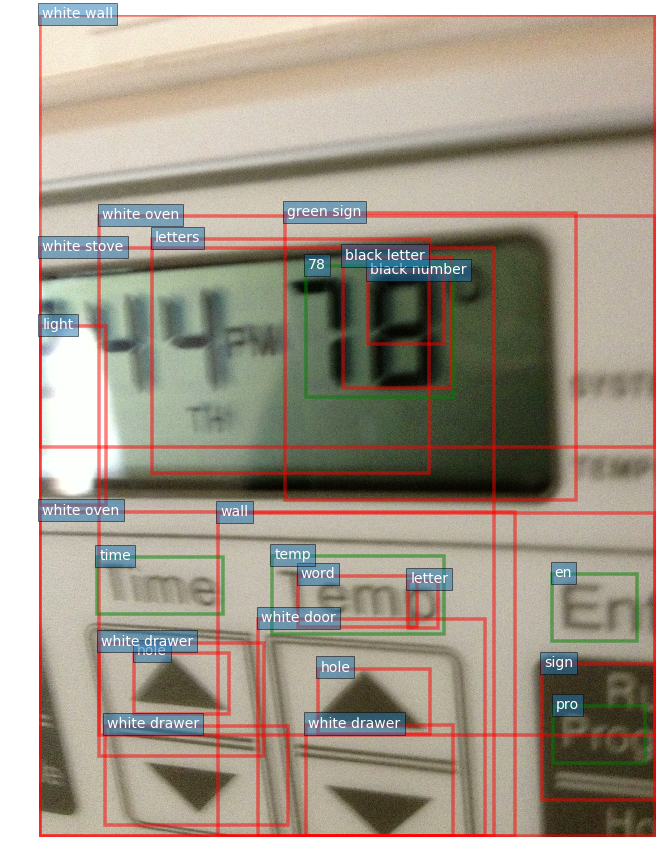

In [5]:
visualize(im_file_path, im_feature_path)
print(question_str)
print("Groundtruth: " + gt)
print("Answer: ")
print_result(question_ids, soft_max_result, ans_dic)

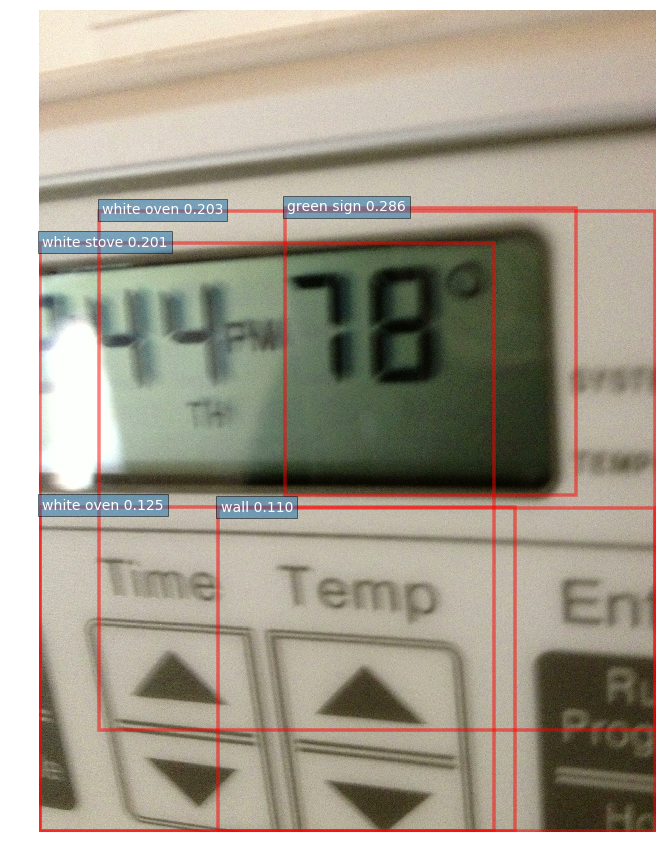

In [6]:
visualize_att(im_file_path, im_feature_path, butd_att,5)

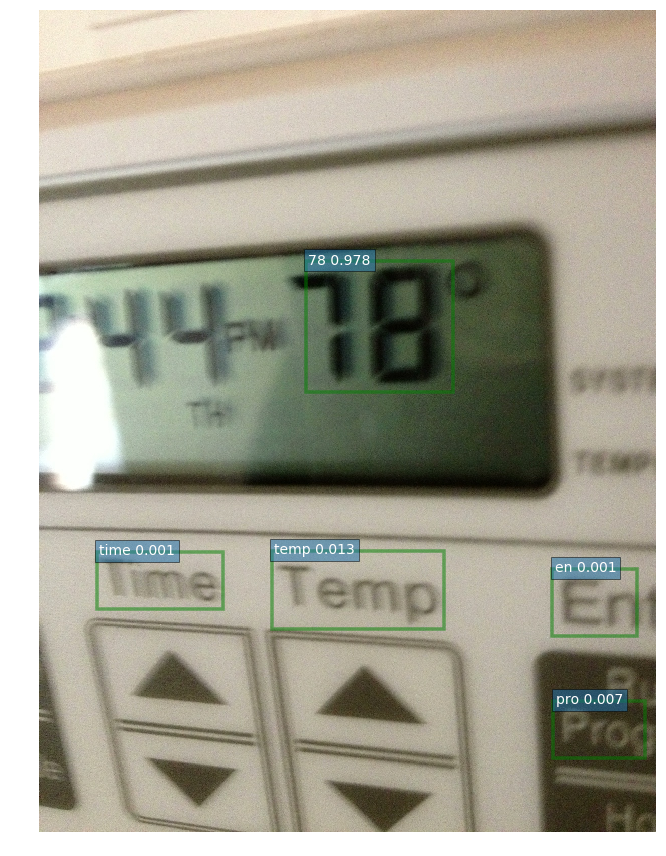

In [7]:
visualize_att(im_file_path, im_feature_path, text_att,5)

In [ ]:
print(sum(butd_att))

In [ ]:
print(sum(text_att))

In [ ]:
print(sorted(butd_att))

In [ ]:
print(sorted(text_att))

In [ ]:
print(len([x for x in text_att if x > 0]))

In [ ]:
print(len([x for x in butd_att if x > 0]))